In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import clone

plt.style.use('ggplot')
plt.rcParams["savefig.format"] = 'svg'
plt.rcParams['image.cmap'] = 'viridis'

np.random.seed(42)

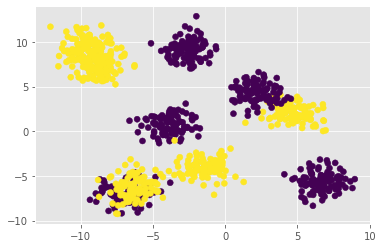

In [2]:
#n_samples=1000
#n_features=2
#x, y = make_blobs(n_samples=n_samples, n_features=n_features,
#                  centers=[[0, 1],[2, 3]], shuffle=False)

n_samples=1000
n_features=2
centers=10
x, blob_id = make_blobs(n_samples=n_samples, n_features=n_features,
                        centers=centers, shuffle=False)
y = blob_id%2

plt.scatter(x[:, 0], x[:, 1], c=y)

dataset_name = 'blobs_s_{}_f_{}_c_manual'.format(n_samples, n_features)

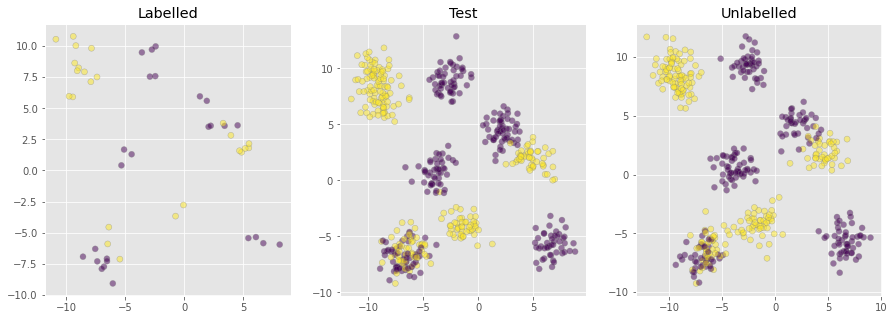

In [3]:
shuffle=True
dataset_name += '_iid' if shuffle else '_ood'
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, shuffle=shuffle)
x_label, x_unlabel, y_label, y_unlabel = train_test_split(x_train, y_train, test_size=0.9, shuffle=False)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.set_title('Labelled')
ax.scatter(x_label[:,0], x_label[:,1], c=y_label, edgecolor='grey', alpha=0.5)
ax = fig.add_subplot(1, 3, 2)
ax.set_title('Test')
ax.scatter(x_test[:,0], x_test[:,1], c=y_test, edgecolor='grey', alpha=0.5)
ax = fig.add_subplot(1, 3, 3)
ax.set_title('Unlabelled')
ax.scatter(x_unlabel[:,0], x_unlabel[:,1], c=y_unlabel, edgecolor='grey', alpha=0.5)
#plt.scatter(x_unlabel[:,0], x_unlabel[:,1], c='white', edgecolors='black', alpha=0.5)
plt.savefig('semi_{}'.format(dataset_name))

In [4]:
# generation of a grid for later model exploration
# define bounds of the domain
min1, max1 = x[:, 0].min()-1, x[:, 0].max()+1
min2, max2 = x[:, 1].min()-1, x[:, 1].max()+1
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

In [5]:
def plot_contourmap(clf, x, y):
    # make predictions for the grid
    yhat = clf.predict_proba(grid)[:,1]
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz)
    plt.colorbar(label='$p(y=1|x)$')
    plt.scatter(x[:,0], x[:,1], c=y, edgecolors='grey',
                alpha=0.5)
    #plt.title('Accuarcy = {:0.3f}'.format(accuracy_score(y_l
    #plt.scatter(x_unlabel[:,0], x_unlabel[:,1], c='white', edgecolors='black',
    #            alpha=0.5)abel, clf.predict(x_label))))

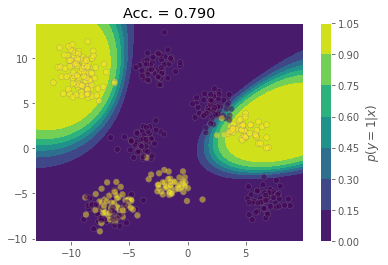

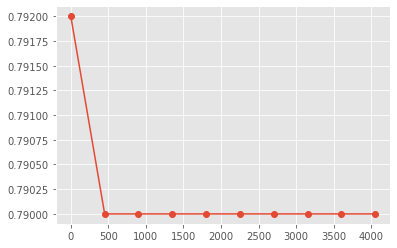

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

model = LogisticRegression()
model = SVC(kernel='rbf', probability=True)

clf = clone(model)
clf.fit(x_label, y_label)
clf.score(x_test, y_test)

performance_list = np.zeros(10)
samples_list = np.zeros(10)
plot_contourmap(clf, x_label, y_label)
performance_list[0] = clf.score(x_test, y_test)
plt.title('Acc. = {:0.3f}'.format(performance_list[0]))
plt.savefig('contourmap_it_0')


for i in range(1, 10):
    plt.clf()
    thresholds = np.max(clf.predict_proba(x_unlabel), axis=1)
    
    predicted_probas = clf.predict_proba(x_unlabel)
    predicted_labels = np.argmax(predicted_probas, axis=1)
    confidences = np.max(predicted_probas, axis=1)
    
    thresholds_sort_idx = np.argsort(-1*confidences)[:(1+i*x_unlabel.shape[0])]
    
    predicted_classes = predicted_labels[thresholds_sort_idx]
    y_train_estiamted = np.concatenate([y_label, predicted_labels[thresholds_sort_idx]])
    x_train_estimated = np.concatenate([x_label, x_unlabel[thresholds_sort_idx]])
    
    clf = clone(model)
    clf.fit(x_train, y_train_estimated)
    plot_contourmap(clf, x_test, y_test)
    performance_list[i] = clf.score(x_test, y_test)
    samples_list[i] = (1+i*x_unlabel.shape[0])
    plt.title('Acc. = {:0.3f}'.format(performance_list[i]))
    plt.savefig('contourmap_it_{}'.format(i))
    

fig, ax = plt.subplots()
ax.plot(samples_list, performance_list, 'o-')